# **Задача 2.**
Решим задачу распознавания лиц с помощью метода опорных векторов.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


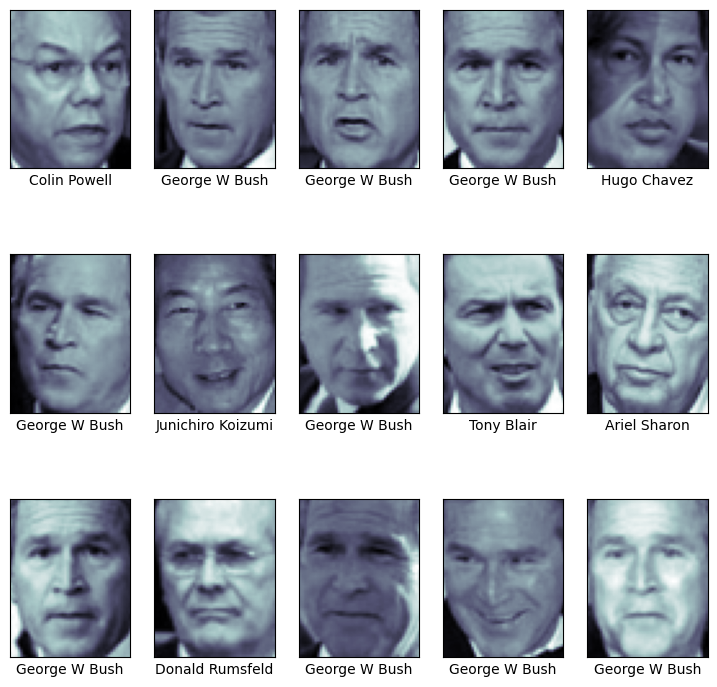

In [5]:
# Нарисуем несколько лиц из датасета
fig, ax = plt.subplots(3, 5, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [6]:
# Каждое изображение имеет размер [62×47] - это примерно 3000 пикселей. Мы можем использовать пиксели как признаки, но давайте понизим размерность пространства признаков.
faces.images.shape

(1348, 62, 47)

In [7]:
# Извлечем 150 самых информативных признаков из данных фотографий методом RandomizedPCA (помним, что это метод уменьшения размерности).

from sklearn.svm import SVC
from sklearn.decomposition import PCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)

Попробуем решить задачу алгоритмом SVM.

In [8]:
svc = SVC(kernel='linear')

model = make_pipeline(pca, svc)

In [9]:

svc = SVC(kernel='linear')

model = make_pipeline(pca, svc)
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [10]:

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 11.9 s, sys: 9.23 s, total: 21.1 s
Wall time: 13.1 s
{'svc__C': 1}


In [11]:

model = grid.best_estimator_

yfit = model.predict(Xtest)

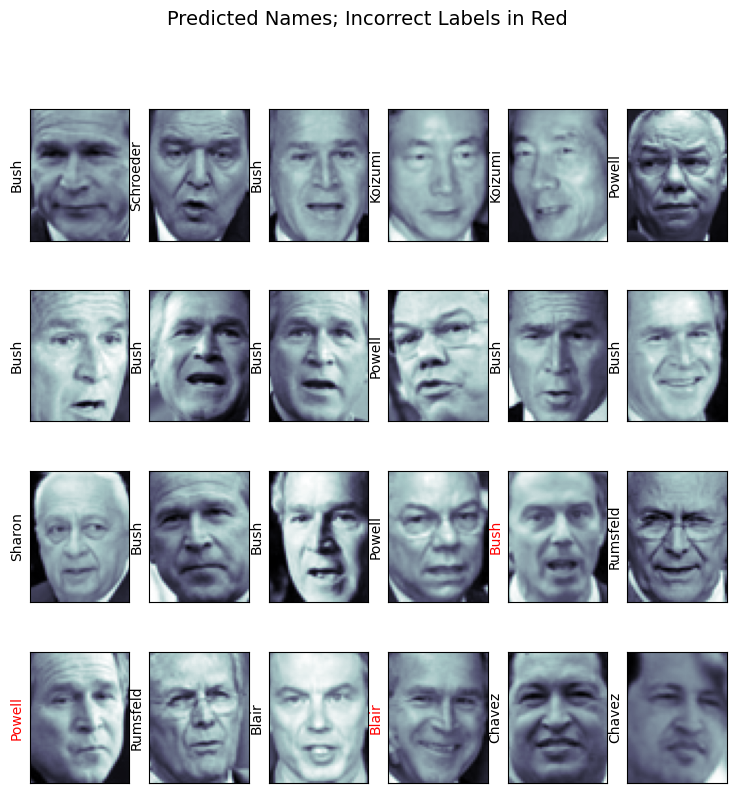

In [12]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Выведем метрики классификации.

In [13]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.67      0.65        15
     Colin Powell       0.78      0.85      0.82        68
  Donald Rumsfeld       0.71      0.71      0.71        31
    George W Bush       0.84      0.79      0.81       126
Gerhard Schroeder       0.68      0.74      0.71        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.73      0.76      0.74        42

         accuracy                           0.78       337
        macro avg       0.77      0.78      0.77       337
     weighted avg       0.79      0.78      0.78       337



Нарисуем матрицу ошибок классификатора.

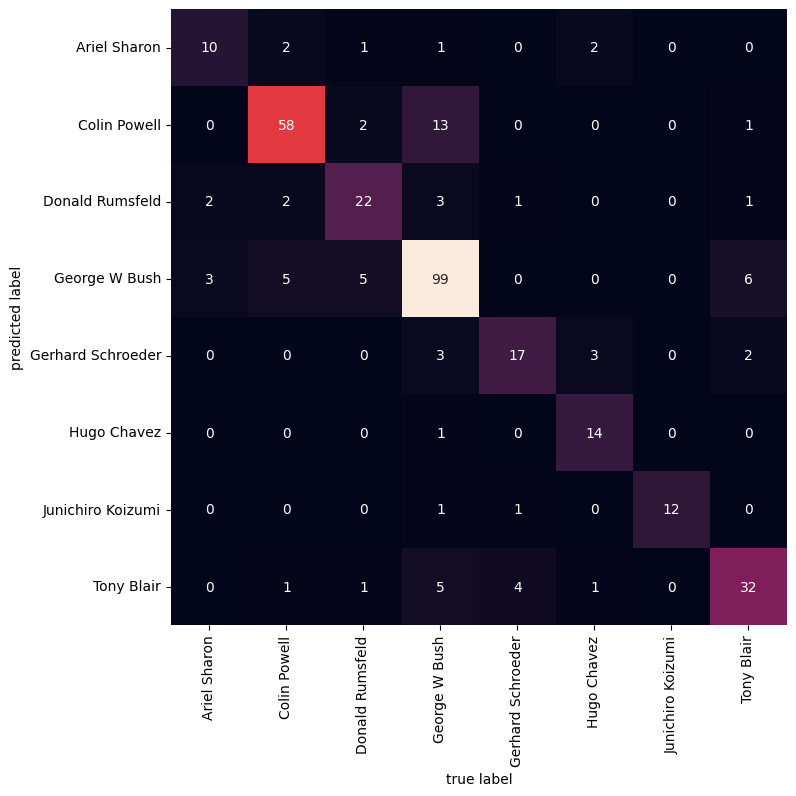

In [14]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(yfit,ytest)

0.7833827893175074

# **Решение нелинейных задач с помощью SVM**

In [16]:

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

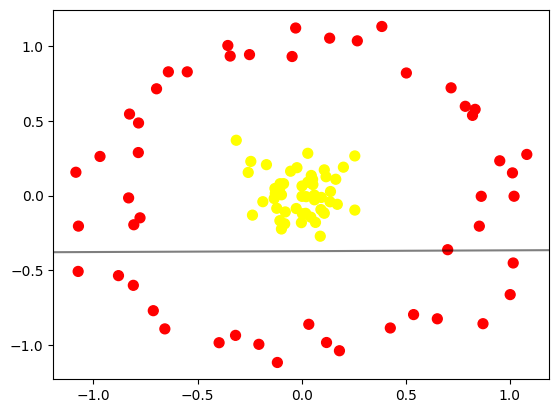

In [17]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [18]:

# Перейдем в пространство новой (большей) размерности. В данном примере в качестве третьей координаты можно использовать радиальную фунцию:

r = np.exp(-(X ** 2).sum(1))


interactive(children=(Dropdown(description='elev', options=(-90, -45, 0, 35, 90), value=-90), IntSlider(value=…

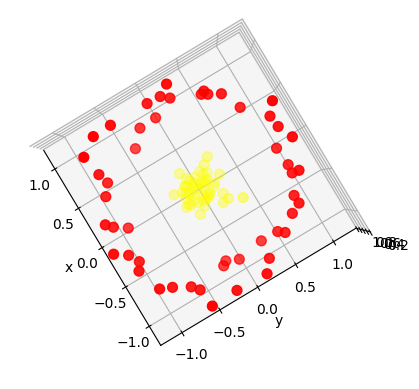

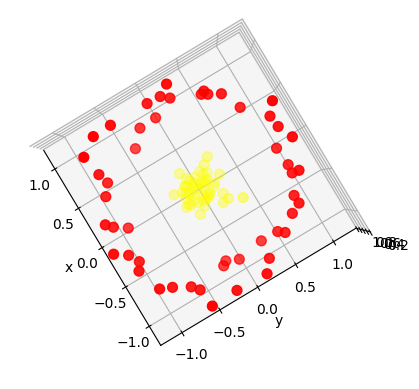

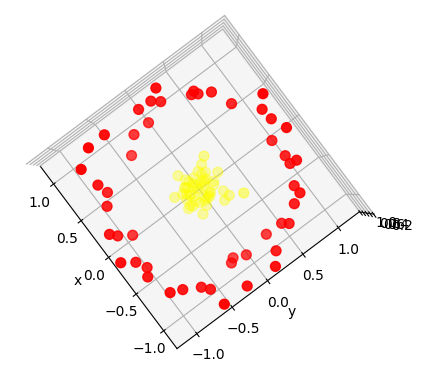

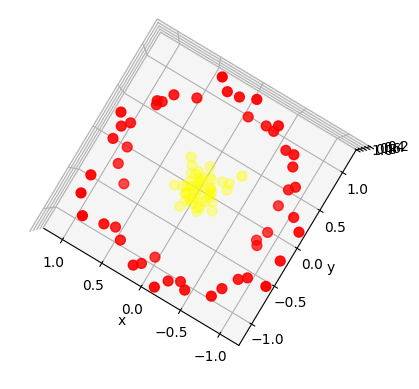

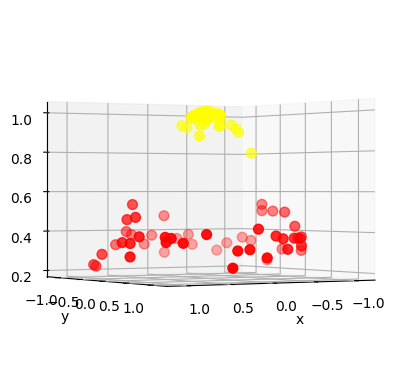

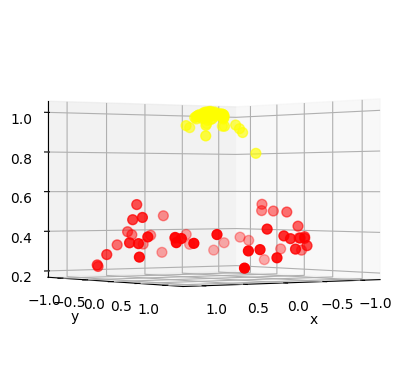

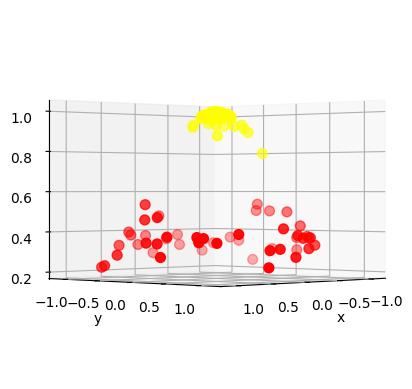

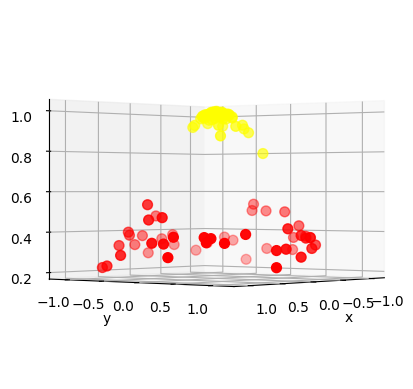

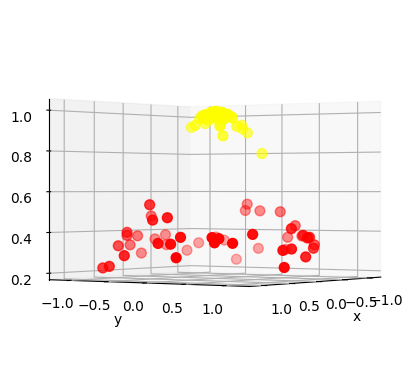

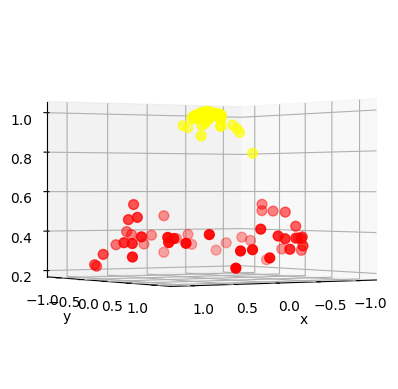

In [19]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45, 0, 35, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

In [20]:
# Видим, что в новом пространстве выборка стала линейно разделимой.
# Решение исходной задачи в новом пространстве с помощью SVM называется ядровым SVM (Kernel SVM).

clf = SVC(kernel='rbf', C=1E6) #rbf = radial basis function
clf.fit(X, y)

SVC(C=1000000.0)

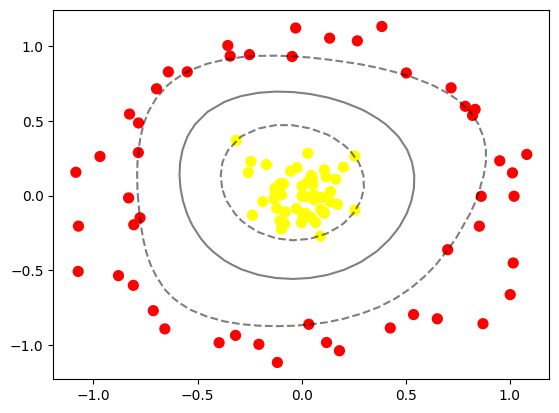

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');